In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

# The functions 
def load_txt_Results_to_dataframe(filename, snapshot_id):
    """
    Load docking results from a text file and return a DataFrame.
    The file must have two columns: the first for ligand name/ID, and the second for the docking score.
    The snapshot_id is used to label the score column (e.g., 'score_snapshot44').
    """
    # Load file and create DataFrame
    df = pd.read_csv(filename, delim_whitespace=True, header=0, names=["ligand", f"score_snapshot{snapshot_id}"])
    
    # Convert score column to numeric for analysis
    df[f"score_snapshot{snapshot_id}"] = pd.to_numeric(df[f"score_snapshot{snapshot_id}"], errors='coerce')

    df[['file_type', 'ligand_identifier']] = df['ligand'].str.split(':', expand=True)
    df[['ligand_id', 'ligand_name']] = df['ligand_identifier'].str.split(r'[-_]', expand=True, n=1)
    
    return df
    

def load_csv_Results_to_dataframe(filename, snapshot_id):
    """
    Load docking results from a csv file and return a DataFrame.
    The file must have two columns: the first for ligand name/ID, and the second for the docking score.
    The snapshot_id is used to label the score column (e.g., 'score_snapshot44').
    """
    # Load file and create DataFrame
    df = pd.read_csv(filename)
    df=df.rename(columns = {'docking_score':f"score_snapshot{snapshot_id}"})
    
    return df
    

def merge_txt_dataframes(*dfs):
    """
    Merge multiple docking results DataFrames on the 'ligand' column, if the format is txt.
    
    Parameters:
    *dfs (pd.DataFrame): Any number of DataFrames to be merged.
    inner = to ensure only the common ligands b/w snapshots are retained.
    if outer: the uncommon ligand names / IDs will get NaN in the score column.
    
    Returns:
    pd.DataFrame: A single DataFrame with all input DataFrames merged on the 'ligand' column.
    """
    # Start with the first DataFrame in the list and merge the rest sequentially
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = merged_df.merge(df, on="ligand", how="inner") 

    return merged_df



def merge_csv_dataframes(*dfs, merge_type="inner"):
    """
    Merge multiple docking results DataFrames on the 'mol_number' column, if the format is csv.

    Parameters:
    *dfs (pd.DataFrame): Any number of DataFrames to be merged.
    merge_type (str): Type of merge to perform, 'inner' for common mol_numbers.

    Returns:
    pd.DataFrame: A single DataFrame with all input DataFrames merged on the 'mol_number' column.
    """
    # Drop unnecessary columns from each DataFrame
    dfs = [df.drop(columns=["source", "mol_number", "ligand"]) for df in dfs]

    # Start with the first DataFrame in the list and merge the rest sequentially
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = merged_df.merge(df, on="order_number", how=merge_type)

    return merged_df






In [ ]:

# Make dataframes from the Vina scoring results
snapshot0_df = load_csv_Results_to_dataframe("result_snap0.csv", 0).drop_duplicates(subset='order_number', keep='first', ignore_index=True)
snapshot446_df = load_csv_Results_to_dataframe("result_snap446.csv", 446).drop_duplicates(subset='order_number', keep='first', ignore_index=True)
snapshot764_df = load_csv_Results_to_dataframe("result_snap764.csv", 764).drop_duplicates(subset='order_number', keep='first', ignore_index=True)
snapshot653_df = load_csv_Results_to_dataframe("result_snap653.csv", 653).drop_duplicates(subset='order_number', keep='first', ignore_index=True)



In [ ]:
# Merge all DataFrames
merged_df = merge_csv_dataframes(snapshot0_df, snapshot446_df, snapshot764_df,snapshot653_df)
#re-order the columns
merged_df = merged_df.loc[:, ['order_number', 'score_snapshot0', 'score_snapshot446', 'score_snapshot653', 'score_snapshot764']]

# Display the merged DataFrame
merged_df

,order_number,score_snapshot0,score_snapshot446,score_snapshot653,score_snapshot764
0,Z1280745057,-12.7,-5.7,-5.5,-6.4
1,Z226359370,-12.4,-5.8,-6.3,-5.4
2,Z2701653577,-12.3,-5.9,-6.1,-6.3
3,Z1239620028,-12.2,-5.9,-4.9,-5.3
4,Z2524830390,-12.2,-5.7,-5.7,-6.5
...,...,...,...,...,...
480735,Z4439096390,-5.0,-5.4,-4.7,-5.4
480736,Z4400903526,-5.0,-2.8,-3.5,-3.5
480737,Z1532991651,-4.9,-3.9,-4.8,-4.6
480738,Z52363778,-4.8,-4.1,-4.0,-4.0


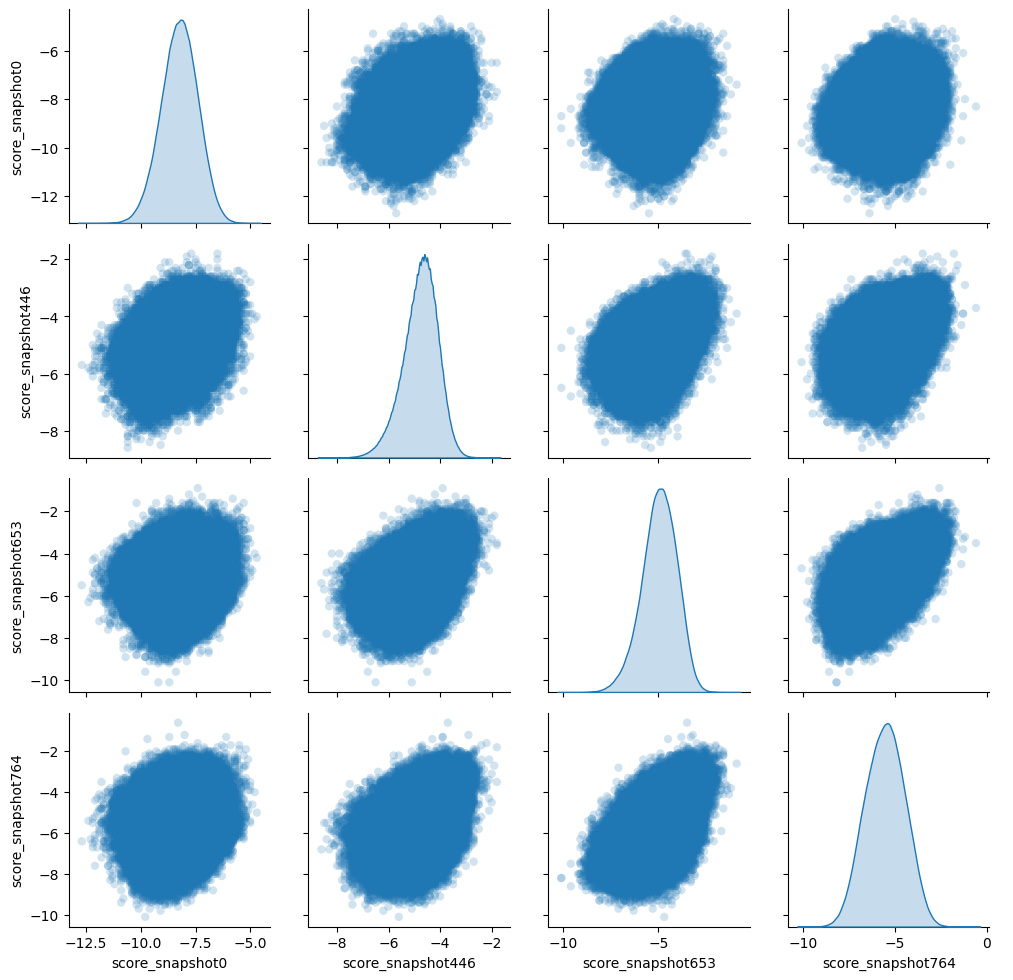

In [13]:
# Drop unnecessary columns
g = merged_df.drop(columns=['order_number'])

# Create PairGrid with optimized scatterplot and kdeplot
plot = sns.PairGrid(g, diag_sharey=False)

# Plot diagonal KDE plots
plot.map_diag(sns.kdeplot, fill=True)

# Plot off-diagonal scatter plots with smaller points for large datasets
plot.map_offdiag(sns.scatterplot, alpha=0.2, edgecolor='none')

# Finalize plot aesthetics
plot.add_legend()
plt.show()


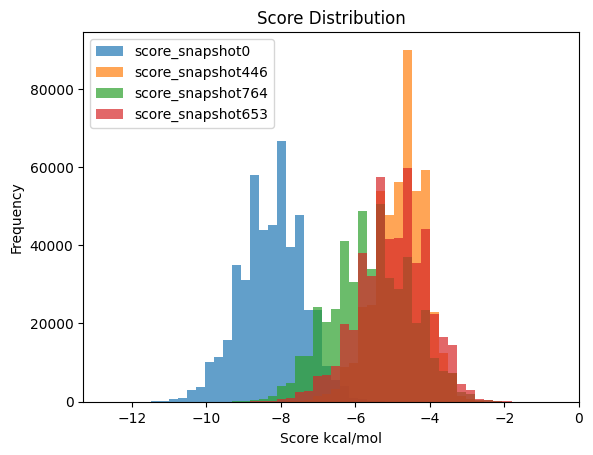

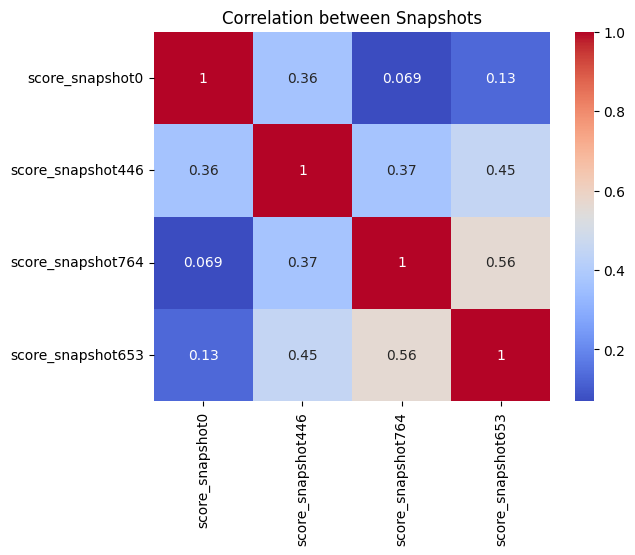

In [11]:
# The visualisation is on all the docked ligands, regardless of their scores.

merged_df[['score_snapshot0', 'score_snapshot446', 'score_snapshot764', 'score_snapshot653']].plot(kind='hist', bins=50, alpha=0.7)
plt.title('Score Distribution')
plt.xlabel('Score kcal/mol')
plt.ylabel('Frequency')
plt.show()


# Correlation heatmap
correlation = merged_df[['score_snapshot0', 'score_snapshot446', 'score_snapshot764', 'score_snapshot653']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Snapshots')
plt.savefig ("Correlation between Snapshots.png", format = "png", dpi = 300)
plt.show()

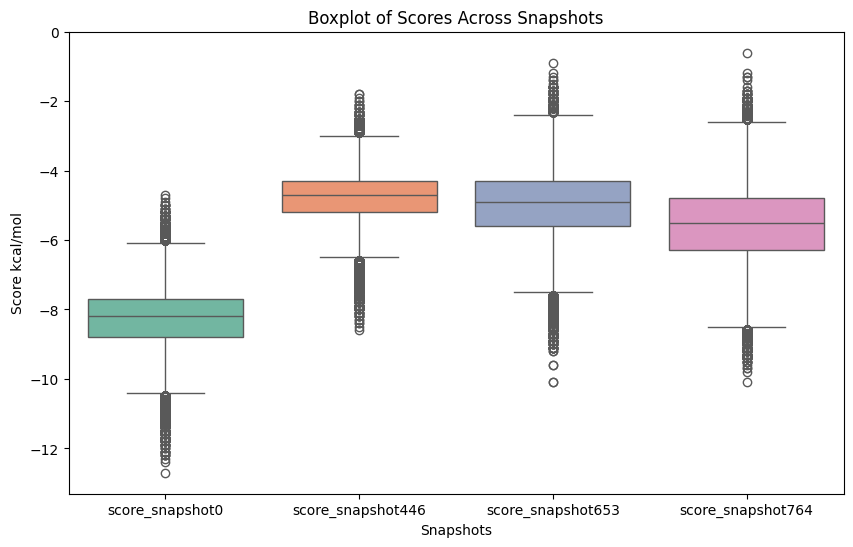

In [16]:
# Create a boxplot for each snapshot score
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df[['score_snapshot0', 'score_snapshot446', 'score_snapshot653', 'score_snapshot764']], palette='Set2')

# Customize plot
plt.title('Boxplot of Scores Across Snapshots')
plt.xlabel('Snapshots')
plt.ylabel('Score kcal/mol')
plt.show()


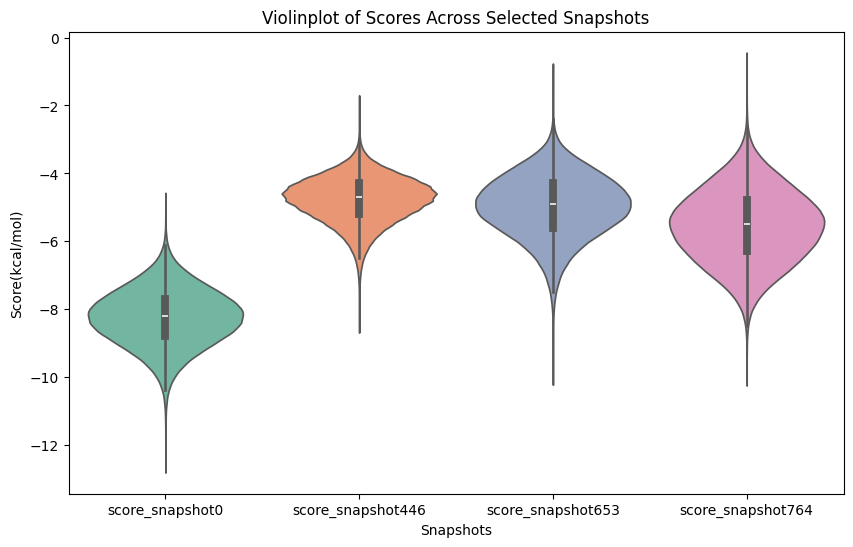

In [10]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=merged_df[['score_snapshot0', 'score_snapshot446', 'score_snapshot653', 'score_snapshot764']], palette='Set2')

# Customize plot
plt.title('Violinplot of Scores Across Selected Snapshots')
plt.xlabel('Snapshots')
plt.ylabel('Score(kcal/mol)')
plt.savefig ("Violinplot of Scores Across Selected Snapshots.png", format = "png", dpi = 300)
plt.show()